# MDI vs DPI Prescribing in the UK, 2023 by clustered ATC code

This notebook has been developed to support the Heidelberg Institute of Global Health’s effort to understand climate-sensitive inhaler prescribing in selected European countries in 2023. The prescription figures are to be clustered per ATC code using their specified categories, with differentiation between DPI or pMDI.


Throughout, detailed comments explain each step for those new to SQL and Python.

### 1. Imports & BigQuery client setup

In [1]:
# Imports & BigQuery client setup
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt


# Authenticate using a local service account JSON file
credentials = service_account.Credentials.from_service_account_file(
    'credentials.json'
)
client = bigquery.Client(
    credentials=credentials,
    project=credentials.project_id
)

### 2. Core SQL: Map VMP → ATC → Form and aggregate prescribing

Below is a subsection of the Entity Relationship Diagram (ERD) illustrating how the key tables link together to perform this mapping and aggregation:

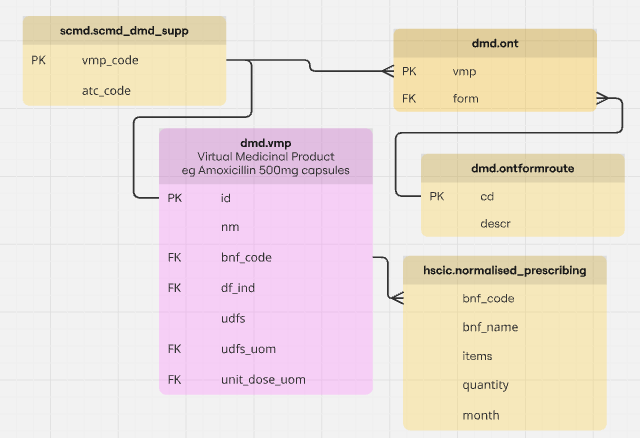

**ERD Explanation:**
- `dmd.vmp` (Virtual Medicinal Product) holds each inhaler’s unique ID (`id`), BNF code (`bnf_code`) and other metadata.
- `dmd.ont` links each VMP (`vmp`) to a form code (`form`), which in turn maps to a form description in `dmd.ontformroute` (`descr`), e.g. `powderinhalation.inhalation` for DPI or `pressurizedinhalation.inhalation` for MDI.
- `scmd.scmd_dmd_supp` associates a VMP (via `vmp_code`) with its corresponding ATC code (`atc_code`).
- `hscic.normalised_prescribing` contains prescribing activity (BNF code, items, quantity, month). We join on the BNF code to fetch prescribing volumes for each inhaler.

In this notebook:
1. We first filter `dmd.ont`+`dmd.ontformroute` to isolate only those VMPs whose form descriptor identifies them as DPI or MDI (stage **Step 2.1**).
2. We then confirm those inhalation forms are respiratory products (BNF codes starting with `030`) by joining to `dmd.vmp` (stage **Step 2.2**).
3. Once we have a clean list of respiratory inhaler VMPs, we join to `scmd.scmd_dmd_supp` to retrieve each inhaler’s ATC code and re-join to `dmd.ont|dmd.ontformroute` to label each as DPI or MDI (stage **Step 2.3**).
4. Separately, we filter `hscic.normalised_prescribing` down to 2023 (`Step 2.4`) to extract prescribing volumes by BNF code.
5. Finally, we aggregate prescribing for each VMP→ATC→form combination to compute totals (`total_items`, `total_quantity`).

These steps ensure we only include valid inhalers (by form and respiratory classification), correctly map to ATC, and gather complete prescribing data for 2023.


In [3]:
sql = """
WITH inhaler_forms AS (
  -- Step 2.1: Identify VMPs whose delivery form is inhalation (DPI or MDI)
  SELECT
    o.vmp            AS vmp_code,
    r.descr          AS form_descr
  FROM `dmd.ont` AS o
  JOIN `dmd.ontformroute` AS r
    ON o.form = r.cd
  WHERE r.descr IN (
    'powderinhalation.inhalation',         -- DPI
    'pressurizedinhalation.inhalation'     -- MDI
  )
), respiratory_inhalers AS (
  -- Step 2.2: From confirmed inhalers, restrict to respiratory BNF codes
  SELECT
    f.vmp_code,
    v.bnf_code
  FROM inhaler_forms AS f
  JOIN `dmd.vmp` AS v
    ON CAST(f.vmp_code AS STRING) = CAST(v.id AS STRING)
  WHERE v.bnf_code LIKE '030%'             -- Respiratory system prefix
), vmp_atc_form AS (
  -- Step 2.3: Map each inhaler VMP to its ATC code and classify as DPI/MDI
  SELECT
    ri.vmp_code,
    ri.bnf_code,
    s.atc_code,
    CASE
      WHEN r.descr = 'powderinhalation.inhalation' THEN 'DPI'
      WHEN r.descr = 'pressurizedinhalation.inhalation' THEN 'MDI'
      ELSE 'Other'
    END AS form
  FROM respiratory_inhalers AS ri
  JOIN `scmd.scmd_dmd_supp` AS s
    ON ri.vmp_code = CAST(s.vmp_code AS INT64)      -- SCMD stores VMP as string
  JOIN `dmd.ont` AS o
    ON ri.vmp_code = o.vmp                        -- Ontology VMP is INT64
  JOIN `dmd.ontformroute` AS r
    ON o.form = r.cd
), prescribing_2023 AS (
  -- Step 2.4: Filter prescribing data to calendar year 2023
  SELECT
    bnf_code,
    bnf_name,
    items
  FROM `hscic.normalised_prescribing`
  WHERE EXTRACT(YEAR FROM month) = 2023
)

-- Final aggregation: join mapped inhalers to prescribing
SELECT
  v.atc_code,
  v.bnf_code,
  p.bnf_name,
  v.form,
  SUM(p.items)     AS total_items
FROM vmp_atc_form AS v
JOIN prescribing_2023 AS p
  ON v.bnf_code = p.bnf_code
GROUP BY
  v.atc_code,
  v.bnf_code,
  p.bnf_name,
  v.form
ORDER BY total_items DESC;
"""

df = client.query(sql).to_dataframe()
# Display top 10 results
display(df.head(10))

,atc_code,bnf_code,bnf_name,form,total_items
0,R03AC02,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,MDI,7315130
1,R03AC02,0301011R0AABUBU,Salbutamol 100micrograms/dose breath actuated ...,MDI,557545
2,R03AC03,0301011V0AABBBB,Terbutaline 500micrograms/dose dry powder inhaler,DPI,216612
3,R03BB04,0301020Q0AAABAB,Tiotropium bromide 18microgram inhalation powd...,DPI,146900
4,R03AK08,0302000C0AABXBX,Beclometasone 100microg/Formoterol 6microg/dos...,MDI,131710
5,R03BB01,0301020I0AAANAN,Ipratropium bromide 20micrograms/dose inhaler ...,MDI,119562
6,R03BA01,0302000C0AABFBF,Beclometasone 100micrograms/dose inhaler CFC free,MDI,100832
7,R03AK07,0302000K0AAAMAM,Budesonide 200mcg/dose / Formoterol 6mcg/dose ...,DPI,87150
8,R03AC12,0301011U0AAAHAH,Salmeterol 25micrograms/dose inhaler CFC free,MDI,80035
9,R03AK06,0302000N0AABFBF,Fluticasone 125mcg/dose / Salmeterol 25mcg/dos...,MDI,72797


### 3. Cluster by ATC code prefixes and calculate DPI share per category

Group ATC codes into the requested clusters:
- **SABA:** R03AC0 
- **LABA:** R03AC1
- **Anticholinergic:** R03BB
- **ICS:** R03BA
- **Combi_1:** R03AK (Adrenergics in combination with corticosteroids or other drugs, excl. anticholinergics)
- **Combi_2:** R03AL (Adrenergics in combination with anticholinergics incl. triple combinations with corticosteroids)
- **Other:** everything else not captured in the requested categories (for data quality checking)

Then calculate the percentage of items delivered as DPI in each cluster.

In [4]:
# Define cluster order and prefixes
cluster_order = ['SABA','LABA','Anticholinergic','ICS','Combi_1','Combi_2','Other']
prefixes = {
    'SABA': 'R03AC0',
    'LABA': 'R03AC1',
    'Anticholinergic': 'R03BB',
    'ICS': 'R03BA',
    'Combi_1': 'R03AK',
    'Combi_2': 'R03AL'
}

# Assign each row to a cluster
df['cluster'] = 'Other'
for name, pref in prefixes.items():
    mask = df['atc_code'].str.startswith(pref, na=False)
    df.loc[mask, 'cluster'] = name

# Aggregate total_items by cluster and form
cluster_totals = (
    df.groupby(['cluster','form'])['total_items']
      .sum()
      .unstack(fill_value=0)
)

# Compute DPI percentage of total
cluster_totals['DPI_percentage'] = (
    cluster_totals.get('DPI', 0) /
    cluster_totals.sum(axis=1) * 100
).round(1)

# Reindex to desired order
d = cluster_totals.reindex(cluster_order)
disp = d[['DPI','MDI','DPI_percentage']].fillna(0)
print("DPI uptake by ATC cluster (items share):")
display(disp)

DPI uptake by ATC cluster (items share):


form,DPI,MDI,DPI_percentage
cluster,,,
SABA,296415,7872692,3.6
LABA,29610,89802,24.8
Anticholinergic,294626,119573,71.1
ICS,75528,292775,20.5
Combi_1,317160,463514,40.6
Combi_2,41051,4401,90.3
Other,51,90,36.2


### 4. Visualise DPI Uptake by Cluster

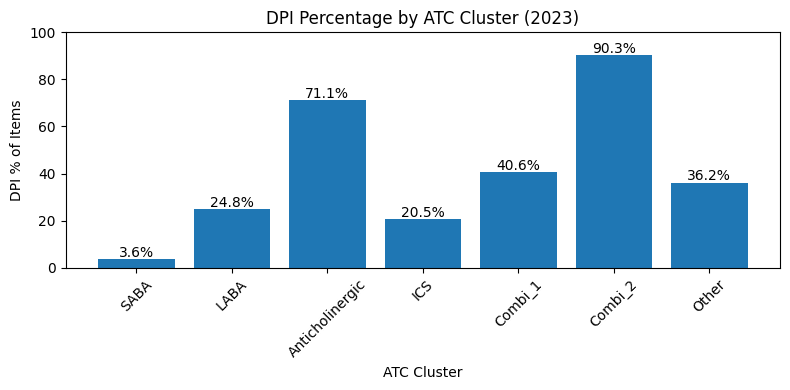

In [5]:
# Bar chart of DPI % by cluster
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(disp.index, disp['DPI_percentage'])
ax.set_title('DPI Percentage by ATC Cluster (2023)')
ax.set_ylabel('DPI % of Items')
ax.set_xlabel('ATC Cluster')
ax.set_ylim(0,100)
ax.ticklabel_format(style='plain', axis='y')
for i, val in enumerate(disp['DPI_percentage']):
    ax.text(i, val+1, f'{val:.1f}%', ha='center')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 5. Inspecting the 'Other' Cluster for Potential Misclassification

In our earlier clustering, inhalers that did not match the predefined ATC prefixes were grouped as **Other**. This step allows us to:

- **Identify misclassified products**: Some inhalers may belong to the other clusters but were not captured. By reviewing every product in the Other cluster, we can spot ATC codes that  require manual review.
- **Understand impact on results**: If key inhalers are missing or misclassified, our DPI/MDI shares by cluster could be biased. This review helps ensure the integrity of our analysis.

Below we list all inhalers placed in the Other cluster, along with their prescribing volumes, to support quality control.


In [7]:
# Filter the DataFrame to the 'Other' cluster
other_cluster = (
    df[df['cluster'] == 'Other']
      # Select key columns for review
      .loc[:, ['atc_code', 'bnf_code', 'bnf_name', 'form', 'total_items']]
)
# Calculate what percentage of overall prescribing items this cluster represents
other_total_items = other_cluster['total_items'].sum()
overall_total_items = df['total_items'].sum()
print(f"Other cluster total items: {other_total_items:,} "
      f"({other_total_items/overall_total_items*100:.3f}% of all inhaler items)")

print("All inhalers in 'Other' cluster with prescribing volumes:")
print(other_cluster.to_string(index=False))

Other cluster total items: 141 (0.001% of all inhaler items)
All inhalers in 'Other' cluster with prescribing volumes:
atc_code        bnf_code                                                    bnf_name form  total_items
 R03BC01 0303010Q0AAANAN               Sodium cromoglicate 5mg/dose inhaler CFC free  MDI           88
     n/a 0302000W0AAAAAA Generic Enerzair Breezhaler 114/46/136microg inh caps + dev  DPI           49
 R05CB16 0307000R0AAAAAA   Mannitol 40mg inhalation powder capsules with two devices  DPI            2
 R03BC03 0303010J0AAADAD                        Nedocromil 2mg/dose inhaler CFC free  MDI            2



*After inspecting the 'Other' cluster, we observe four products in this group. Three of these (Sodium cromoglicate, Mannitol, and Nedocromil) are not part of the defined therapeutic clusters (SABA, LABA, SAMA, ICS, Combi1, or Combi2), so their placement here is expected. However, "Generic Enerzair Breezhaler 114/46/136microg inh caps + dev" appears under 'Other' due to a missing ATC code (n/a), indicating a misclassification (should be in cluster Combi2. We have chosen not to adjust this misclassification because the 'Other' cluster accounts for only 0.001% of all inhaler prescribing in 2023, so its impact on the overall analysis is minimal.*    

### 6. Quality-Check: Top 10 Inhalers per ATC Cluster

For each ATC cluster (e.g. SABA, LABA, etc.), we pull the ten products with the highest prescribing volume (total_items). This helps verify that our clustering logic is correct and that each category contains the expected inhalers.


In [8]:
# Create an empty dictionary to hold each cluster’s “top 10” DataFrame
cluster_top10 = {}

# Loop through each cluster name in the prescribed order
for cluster in cluster_order:
    # 1) Subset the main DataFrame to only rows in that cluster
    subset = df[df['cluster'] == cluster]
    
    # 2) From that subset, find the top 10 products by total_items
    #    - .nlargest(10, 'total_items') selects the 10 largest values in 'total_items'
    #    - .loc[:, [...]] then narrows down to the columns we want to display
    top10 = (
        subset
          .nlargest(10, 'total_items')
          .loc[:, [
              'cluster',      # The cluster name (redundant here but useful for context)
              'atc_code',     # ATC classification code
              'bnf_code',     # BNF code (presentation code)
              'bnf_name',     # Human-readable inhaler name
              'form',         # DPI vs MDI
              'total_items'   # Number of prescription items in 2023
          ]]
    )
    
    # 3) Store this “top 10” DataFrame in our dictionary for potential later use
    cluster_top10[cluster] = top10
    
    # 4) Print a header so the console output is clearly separated by cluster
    print(f"\nTop 10 inhalers in cluster '{cluster}' by items (2023):")
    
    # 5) Print the DataFrame to the console as a clean ASCII table
    #    - .to_string(index=False) prints all columns, no row index numbers
    print(top10.to_string(index=False))


Top 10 inhalers in cluster 'SABA' by items (2023):
cluster atc_code        bnf_code                                                   bnf_name form  total_items
   SABA  R03AC02 0301011R0AAAPAP             Salbutamol 100micrograms/dose inhaler CFC free  MDI      7315130
   SABA  R03AC02 0301011R0AABUBU Salbutamol 100micrograms/dose breath actuated inh CFC free  MDI       557545
   SABA  R03AC03 0301011V0AABBBB          Terbutaline 500micrograms/dose dry powder inhaler  DPI       216612
   SABA  R03AC02 0301011R0AAAQAQ           Salbutamol 200micrograms/dose dry powder inhaler  DPI        46005
   SABA  R03AC02 0301011R0AABZBZ           Salbutamol 100micrograms/dose dry powder inhaler  DPI        32274
   SABA  R03AC02 0301011R0AACBCB Salbutamol 100microg/dose dry pdr inhalation cart with dev  DPI          972
   SABA  R03AC02 0301011R0AACCCC Salbutamol 100micrograms/dose dry pdr inhalation cartridge  DPI          552
   SABA  R03AC02 0301011R0AAAAAA                      Salbutamol 100

### 7. Export Full Inhaler List to CSV for 2023

In addition to the top-10 lists, we allow exporting every inhaler prescribed in 2023 with the following fields: cluster, atc_code, bnf_code, bnf_name, form, total_items. This CSV can be shared or further analyzed outside of this notebook.

In [9]:
# Select the desired columns from the main DataFrame 'df'
full_inhaler_list = df.loc[:, ['cluster', 'atc_code', 'bnf_code', 'bnf_name', 'form', 'total_items']]

# Define a file path for the CSV output
output_path = 'all_inhalers_2023.csv'

# Export to CSV (index=False to omit row numbers)
full_inhaler_list.to_csv(output_path, index=False)
print(f"Full inhaler list exported to: {output_path}")

# Display the first few rows of the DataFrame for confirmation
display(full_inhaler_list.head(10))

Full inhaler list exported to: all_inhalers_2023.csv


,cluster,atc_code,bnf_code,bnf_name,form,total_items
0,SABA,R03AC02,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,MDI,7315130
1,SABA,R03AC02,0301011R0AABUBU,Salbutamol 100micrograms/dose breath actuated ...,MDI,557545
2,SABA,R03AC03,0301011V0AABBBB,Terbutaline 500micrograms/dose dry powder inhaler,DPI,216612
3,Anticholinergic,R03BB04,0301020Q0AAABAB,Tiotropium bromide 18microgram inhalation powd...,DPI,146900
4,Combi_1,R03AK08,0302000C0AABXBX,Beclometasone 100microg/Formoterol 6microg/dos...,MDI,131710
5,Anticholinergic,R03BB01,0301020I0AAANAN,Ipratropium bromide 20micrograms/dose inhaler ...,MDI,119562
6,ICS,R03BA01,0302000C0AABFBF,Beclometasone 100micrograms/dose inhaler CFC free,MDI,100832
7,Combi_1,R03AK07,0302000K0AAAMAM,Budesonide 200mcg/dose / Formoterol 6mcg/dose ...,DPI,87150
8,LABA,R03AC12,0301011U0AAAHAH,Salmeterol 25micrograms/dose inhaler CFC free,MDI,80035
9,Combi_1,R03AK06,0302000N0AABFBF,Fluticasone 125mcg/dose / Salmeterol 25mcg/dos...,MDI,72797
